<a href="https://colab.research.google.com/github/JuvignyEnsta/Cours_Ensta_2026/blob/main/travaux_diriges/tp5/TP_numero_cinq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configurer votre colab pour le calcul sur GPU
Dans le menu au dessus, choisir le sous-menu **Exécution** puis l'option **Modifier le type d'exécution**.

Une fenêtre apparaît où vous pouvez choisir un accélérateur matériel. Choisissez un *GPU* puis *enregistrer* votre choix.

Afin de vérifier que vous avez bien configuré votre session pour utiliser un GPU, exécuter le code ci-dessous (en passant la souris, une petite flèche pour l'exécuter apparaît).

Si tout se passe bien, un tableau (en ascii) apparaît avec le type de carte (et son architecture) auquel vous avez accès. Si un message d'erreur apparaît, vérifiez dans **Modifier le type d'exécution** que l'accélérateur matériel est bien configuré pour un *GPU*

In [1]:
!nvidia-smi

Fri Feb 20 16:03:18 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   46C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Installation de PyCuda

Pour utiliser le GPU sous Python il faut soit installer **PyCuda** pour effectuer des calculs, soit **PyTorch** pour effectuer du machine learning accéléré par les GPUs.

Dans ce TP, nous nous bornerons uniquement à effectuer des calculs sur GPU !

Pour cela, il faut d'abord installer pyCuda et donc exécuter le code ci-dessous (toujours en appuyant sur la flèche pour exécuter le code, et attendez, cela prend un petit moment...)

In [2]:
!pip install pycuda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 33.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 14.6 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2026.1-cp312-cp312-linux_x86_64.whl size=659448 sha256=1e89a595bbe74f08d41d6c705769e918e735b745fb8a02700a771322b590e7d5
  Stored in directory: /root/.cache/pip/wheels/90/2a/71/75ec0cc316cc0ff494bfffa2935e02580129cb7f859a0cfd8f
Successfully built pycuda


# Vérification du bon fonctionnement du module PyCuda

Afin de vérifier le bon fonctionnement de l'installation, nous allons écrire un script Cuda qui servira en même temps d'exemple pour le TP d'aujourd'hui. Ce script sera scindé en plusieurs morceaux et commenté pour que vous compreniez chaque partie du code.

Ce code sera très simple : on va créer une matrice 4x4 avec des données prises "au hasard" (mais avec une graine aléatoire fixée, donc...) , recopier ce tableau dans la mémoire de la carte graphique et demander à la carte graphique de doubler la valeur de chaque élément de la matrice puis de recopier dans la mémoire de l'ordinateur les valeurs calculées. On affiche ensuite la matrice initiale et la matrice transformée.

Dans un premier temps, chargeons les modules python nécessaire à l'exécution d'un noyau Cuda (**Remarque** : l'importation de ces modules n'est nécessaire qu'une seule fois pour **TOUTE** la session. Il sera donc inutile de reimporter ces modules dans le reste du TD !) :

In [3]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

Créons à l'aide de numpy un tableau *a* dont les valeurs aléatoires sont issues d'une graine fixée :

In [5]:
import numpy
numpy.random.seed(1729)
a = numpy.random.randn(4,4) # Sous forme de matrice 4 x 4

Puisque certaines cartes graphiques supportent mal le double précision, nous allons demander à Python que les éléments de *a* soient en simple précision :

In [6]:
a = a.astype(numpy.float32)
print(a.nbytes)

64


Nous allons ensuite allouer de la place mémoire sur la mémoire vive du GPU. Comme en C, la place mémoire est exprimée en *Octets* :

In [7]:
a_gpu = cuda.mem_alloc(a.nbytes)

Une fois la réservation sur le GPU de faite, on recopie les valeurs de *a* dans le tableau *a_gpu* que l'on vient de réserver (htod signifie host **to** device):

In [8]:
cuda.memcpy_htod(a_gpu, a)

Il faut ensuite écrire le noyau qui s'exécutera sur la carte graphique à l'aide du langage CUDA (qui est une extension du langage C).

**Remarquez** dans le code qu'on s'assure que les indices donnés par les numéros de threads ne dépassent pas la dimension de la matrice !

In [9]:
mod = SourceModule("""
__global__ void doublify( int dim_x, int dim_y, float *a )
{
  if ((threadIdx.x < dim_x) && (threadIdx.y < dim_y))
  {
    int idx = threadIdx.x + threadIdx.y * dim_x;
    a[idx] *= 2;
  }
}
""")

Nous allons récupérer ensuite un "handle" sur le noyau cuda que l'on vient de créer (en invoquant le nom de la fonction) et l'invoquer sur la carte graphique en dimensionnant la grille de calcul à l'aide de *block=(4,4,1)* (et en l'adaptant aux dimensions de la matrice).

Ici, nous n'avons pas besoin de configurer de grilles car la dimension de la matrice *a* est petite, mais comme la taille d'un bloc dans une direction est limitée à 256, pour des cas plus gros, il faudra également passer une grille en paramètre à l'aide de *grid=(x,y,z)* où *x,y* et *z* sont des valeurs entières positives et utiliser dans le noyau cuda les valeurs *x,y* et *z* de **blockIdx** et **blockDim**.

**REMARQUE IMPORTANTE** : Le noyau cuda ne veut que des types C basiques en argument. Or un entier python est tout sauf un type basique du C. Donc pour passer un argument entier à un noyau cuda, il faut créer un entier 32 bits à l'aide de numpy.int32

In [10]:
func = mod.get_function("doublify")
dim = numpy.int32(4)
func(dim, dim, a_gpu, block=(4,4,1))

Il ne reste plus qu'à récupérer les nouvelles valeurs de la matrice en transférant les données de la matrice contenue par le GPU dans un tableau numpy se trouvant dans la RAM de l'ordinateur (dtoh signifie device **to** host) :

In [11]:
a_doubled = numpy.empty_like(a)
cuda.memcpy_dtoh(a_doubled, a_gpu)

Il ne reste plus qu'à afficher la matrice initiale puis la matrice obtenue par le calcul sur GPU :

In [12]:
print(f"a : {a}")
print(f"a_gpu : {a_doubled}")

a : [[-0.6873394  -0.82099473  1.6523609  -0.57529306]
 [ 1.0989678   0.92594606 -0.9934138  -0.8582211 ]
 [ 0.07488676  0.5293555   0.12095155 -0.22442362]
 [-1.5566785   0.05594088  0.16147153 -2.1346416 ]]
a_gpu : [[-1.3746789  -1.6419895   3.3047218  -1.1505861 ]
 [ 2.1979356   1.8518921  -1.9868276  -1.7164422 ]
 [ 0.14977352  1.058711    0.2419031  -0.44884723]
 [-3.113357    0.11188176  0.32294306 -4.2692833 ]]


## Exercices de mises en bouche

En vous inspirant du programme commenté ci-dessus, écrivez un code avec un noyau Cuda qui fait la somme de deux vecteurs de réels simples précisions et qui range le résultat dans un troisième vecteur.

On s'exercera à utiliser des vecteurs de "grandes" dimensions (> 256) afin de s'entrainer à calculer des indices globaux dans le noyau cuda à l'aide de *threadIdx.x*, *blockIdx.x* et *dimBlock.x*.

Ecrivez (ou copier coller) votre code dans la cellule ci-dessous

In [24]:
import numpy as np
import pycuda.autoinit
import pycuda.driver as cuda
from pycuda.compiler import SourceModule

# -----------------------------
# 1) Host Data Initialization
# -----------------------------
n = 1_000_000
np.random.seed(1729)

# Enforce float32 to match C/CUDA types
a = np.random.randn(n).astype(np.float32)
b = np.random.randn(n).astype(np.float32)
c = np.empty_like(a)

# -----------------------------
# 2) GPU Memory Allocation & HtoD Copy
# -----------------------------
# Allocate memory on the device (GPU)
a_gpu = cuda.mem_alloc(a.nbytes)
b_gpu = cuda.mem_alloc(b.nbytes)
c_gpu = cuda.mem_alloc(c.nbytes)

# Copy data from Host (CPU) to Device (GPU)
cuda.memcpy_htod(a_gpu, a)
cuda.memcpy_htod(b_gpu, b)

# -----------------------------
# 3) CUDA Kernel Definition
# -----------------------------
mod = SourceModule(r"""
__global__ void vadd(const int n, const float *a, const float *b, float *c)
{
    // Calculate global thread ID across the entire grid
    int i = blockIdx.x * blockDim.x + threadIdx.x;

    // Boundary check: ensure threads beyond 'n' do nothing
    if (i < n) {
        c[i] = a[i] + b[i];
    }
}
""", options=["-O3"])

vadd = mod.get_function("vadd")

# -----------------------------
# 4) Grid/Block Configuration & Kernel Launch
# -----------------------------
tpb = 256 # Threads per block (256 or 512 are standard optimal values)

# Calculate total blocks needed (equivalent to math.ceil(n / tpb))
blocks = (n + tpb - 1) // tpb

# Launch kernel.
# IMPORTANT: n must be cast to np.int32 to match the C 'int' type.
vadd(np.int32(n), a_gpu, b_gpu, c_gpu,
     block=(tpb, 1, 1), grid=(int(blocks), 1, 1))

cuda.Context.synchronize()

# -----------------------------
# 5) DtoH Copy & Verification
# -----------------------------
# Copy results back from Device (GPU) to Host (CPU)
cuda.memcpy_dtoh(c, c_gpu)

# Verify against CPU calculation
ref = a + b
max_err = float(np.max(np.abs(c - ref)))

print(f"n = {n}")
print(f"Threads per block = {tpb} | Total blocks = {blocks}")
print(f"Max Error = {max_err}")

n = 1000000
Threads per block = 256 | Total blocks = 3907
Max Error = 0.0


Une fois le code mis au point, recopiez le ci-dessous et adaptez le pour additionner deux matrices carrées dans une troisième.

In [25]:
import numpy as np

import pycuda.autoinit
import pycuda.driver as cuda
from pycuda.compiler import SourceModule

# -----------------------------
# 1) Square matrices (N x N)
# -----------------------------
N = 1024  # square and reasonably large
np.random.seed(1729)

A = np.random.randn(N, N).astype(np.float32)
B = np.random.randn(N, N).astype(np.float32)
C = np.empty_like(A)

# Flatten to a contiguous 1D view (row-major) for simple linear indexing on GPU
A_flat = A.ravel()
B_flat = B.ravel()
C_flat = C.ravel()
n = A_flat.size  # total elements = N*N

# -----------------------------
# 2) GPU memory allocation + host-to-device copies
# -----------------------------
A_gpu = cuda.mem_alloc(A_flat.nbytes)
B_gpu = cuda.mem_alloc(B_flat.nbytes)
C_gpu = cuda.mem_alloc(C_flat.nbytes)

cuda.memcpy_htod(A_gpu, A_flat)
cuda.memcpy_htod(B_gpu, B_flat)

# -----------------------------
# 3) CUDA kernel: element-wise addition
#    We treat the matrix as a 1D array of length N*N
# -----------------------------
mod = SourceModule(r"""
__global__ void madd(const int n, const float *A, const float *B, float *C)
{
    // Global 1D index
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx < n) C[idx] = A[idx] + B[idx];
}
""", options=["-O3"])

madd = mod.get_function("madd")

# -----------------------------
# 4) Kernel launch configuration
# -----------------------------
tpb = 256
blocks = (n + tpb - 1) // tpb  # ceil(n/tpb)

madd(np.int32(n), A_gpu, B_gpu, C_gpu,
     block=(tpb, 1, 1), grid=(int(blocks), 1, 1))

cuda.Context.synchronize()

# -----------------------------
# 5) Device-to-host copy + reshape + correctness check
# -----------------------------
cuda.memcpy_dtoh(C_flat, C_gpu)

# Rebuild 2D matrix view
C = C_flat.reshape((N, N))

# CPU reference and max error
ref = A + B
max_err = float(np.max(np.abs(C - ref)))

print("N =", N, "| n = N*N =", n)
print("tpb =", tpb, "| blocks =", blocks)
print("max_err =", max_err)
print("OK" if max_err == 0.0 else "OK (float tolerance)")

N = 1024 | n = N*N = 1048576
tpb = 256 | blocks = 4096
max_err = 0.0
OK


# Exercice final

Nous allons de nouveau nous intéresser à l'ensemble de Mandelbrot. La cellule ci-dessous contient un code permettant de calculer à l'aide de numpy un ensemble de mandelbrot (le code est simplifié par rapport aux codes sur CPU pour faciliter le TP même si il utilise la notation vectorielle de numpy (il faudra y faire attention pour code le noyau cuda !) : code repris de https://stackoverflow.com/questions/60467316/displaying-mandelbrot-set-in-python-using-matplotlib-pyplot-and-numpy).

Transformez le de sorte que sur GPU, chaque thread calcule un pixel de l'image de destination.

/tmp/ipython-input-321746850.py:39: RuntimeWarning: overflow encountered in multiply
  diverged = (z_cpu.real * z_cpu.real + z_cpu.imag * z_cpu.imag) > 4.0
/tmp/ipython-input-321746850.py:39: RuntimeWarning: overflow encountered in add
  diverged = (z_cpu.real * z_cpu.real + z_cpu.imag * z_cpu.imag) > 4.0
/tmp/ipython-input-321746850.py:37: RuntimeWarning: overflow encountered in multiply
  z_cpu = z_cpu * z_cpu + c_cpu
/tmp/ipython-input-321746850.py:37: RuntimeWarning: invalid value encountered in multiply
  z_cpu = z_cpu * z_cpu + c_cpu


=== Mandelbrot (1 thread = 1 pixel) ===
Resolution: 1000 x 1000 = 1,000,000 pixels | loop=100
Block: (16,16) | Grid: (63,63)

--- Timings (ms) ---
CPU reference: 430.49 ms
GPU compile (info): 408.79 ms
GPU kernel: 0.25 ms
GPU DtoH copy: 1.25 ms
GPU total: 1.50 ms

--- Performance ---
Kernel throughput: 3952.69 MPix/s
Speedup (CPU/kernel): 1701.59 x
Speedup (CPU/total):  287.28 x

--- Correctness / stats ---
Max |color_gpu - color_cpu|: 104
Inside-set fraction (color=loop+5): 12.85 %
Mean escape iteration (capped): 15.28


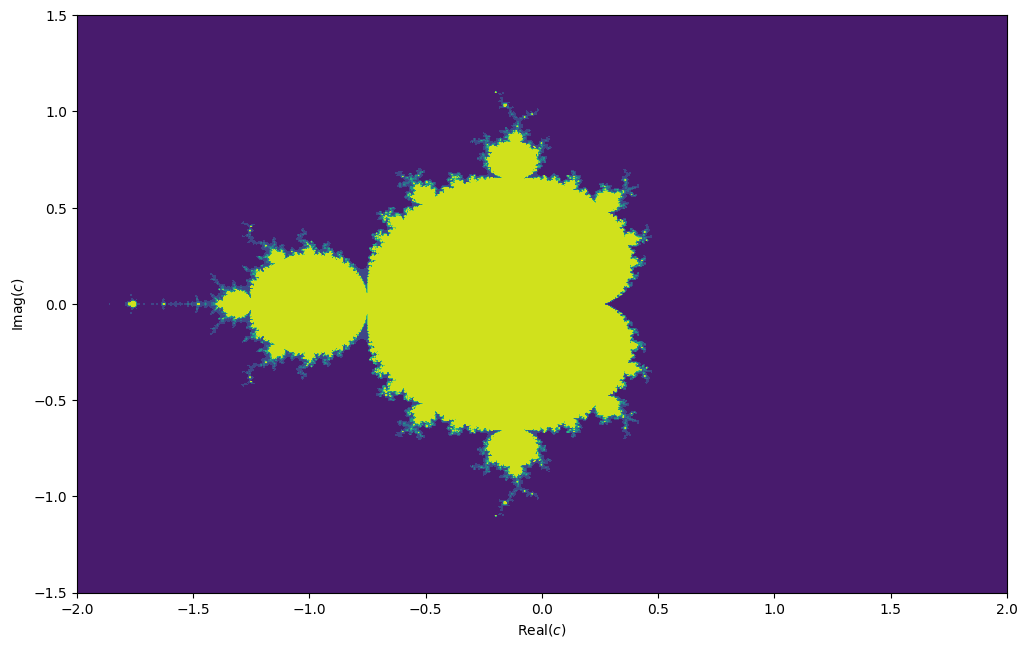

In [23]:
import numpy as np
import pylab as plt
import time

import pycuda.autoinit
import pycuda.driver as cuda
from pycuda.compiler import SourceModule

# -----------------------------
# Parameters
# -----------------------------
loop = 100          # max iterations per pixel
div  = 1000         # image resolution: div x div

xmin, xmax = -2.0,  2.0
ymin, ymax = -1.5,  1.5

# Axes (float32 to match GPU arithmetic)
x = np.linspace(xmin, xmax, div, dtype=np.float32)
y = np.linspace(ymin, ymax, div, dtype=np.float32)

dx = np.float32((xmax - xmin) / (div - 1))
dy = np.float32((ymax - ymin) / (div - 1))

# ============================================================
# 1) CPU reference (vectorized NumPy) to validate the GPU result
# ============================================================
t0 = time.perf_counter()

c_cpu = (x[:, None] + 1j * y[None, :]).astype(np.complex64)
z_cpu = np.zeros_like(c_cpu, dtype=np.complex64)

# Default value for points that do NOT diverge within 'loop'
color_cpu = np.full((div, div), loop + 5, dtype=np.int32)

for n in range(loop):
    z_cpu = z_cpu * z_cpu + c_cpu
    # Divergence test: |z|^2 > 4  (avoid sqrt)
    diverged = (z_cpu.real * z_cpu.real + z_cpu.imag * z_cpu.imag) > 4.0
    # Store the first iteration where divergence is detected
    newly = diverged & (color_cpu == (loop + 5))
    color_cpu[newly] = n

t1 = time.perf_counter()
cpu_ms = (t1 - t0) * 1000.0

# ============================================================
# 2) GPU: one thread computes one pixel (escape-time algorithm)
# ============================================================
color_gpu = np.empty((div, div), dtype=np.int32)
color_gpu_dev = cuda.mem_alloc(color_gpu.nbytes)

# Kernel compilation time is reported but typically excluded from performance
t2 = time.perf_counter()

mod = SourceModule(r"""
__global__ void mandelbrot(int div, int loop,
                           float xmin, float ymin,
                           float dx, float dy,
                           int *color)
{
    // Pixel coordinates (i, j) from 2D thread/block indexing
    int i = (int)(blockIdx.x * blockDim.x + threadIdx.x); // x (real axis)
    int j = (int)(blockIdx.y * blockDim.y + threadIdx.y); // y (imag axis)
    if (i >= div || j >= div) return;

    // Map pixel (i,j) to complex plane point c = cr + i*ci
    float cr = xmin + (float)i * dx;
    float ci = ymin + (float)j * dy;

    // z0 = 0
    float zr = 0.0f, zi = 0.0f;

    // Default: inside set (no divergence within 'loop')
    int col = loop + 5;

    // Iterate z <- z^2 + c and detect first divergence
    for (int n = 0; n < loop; ++n) {
        float zr_new = zr*zr - zi*zi + cr;
        float zi_new = 2.0f*zr*zi + ci;
        zr = zr_new;
        zi = zi_new;

        // |z|^2 > 4 => diverged
        if (zr*zr + zi*zi > 4.0f) { col = n; break; }
    }

    // Store result in a linear row-major buffer: index = j*div + i
    color[j * div + i] = col;
}
""", options=["-O3"])

mandel = mod.get_function("mandelbrot")

t3 = time.perf_counter()
compile_ms = (t3 - t2) * 1000.0

# 2D launch configuration
tx, ty = 16, 16
grid_x = (div + tx - 1) // tx
grid_y = (div + ty - 1) // ty

# Warm-up run (avoid first-run effects in timing)
mandel(np.int32(div), np.int32(loop),
       np.float32(xmin), np.float32(ymin),
       np.float32(dx), np.float32(dy),
       color_gpu_dev,
       block=(tx, ty, 1), grid=(int(grid_x), int(grid_y), 1))
cuda.Context.synchronize()

# Kernel timing (compute only) using CUDA events
start = cuda.Event()
end = cuda.Event()
start.record()

mandel(np.int32(div), np.int32(loop),
       np.float32(xmin), np.float32(ymin),
       np.float32(dx), np.float32(dy),
       color_gpu_dev,
       block=(tx, ty, 1), grid=(int(grid_x), int(grid_y), 1))

end.record()
end.synchronize()
kernel_ms = start.time_till(end)

# Host transfer time (result copy back)
t4 = time.perf_counter()
cuda.memcpy_dtoh(color_gpu, color_gpu_dev)
t5 = time.perf_counter()
dtoh_ms = (t5 - t4) * 1000.0

gpu_total_ms = kernel_ms + dtoh_ms

# ============================================================
# 3) Metrics + correctness checks
# ============================================================
max_diff = int(np.max(np.abs(color_gpu - color_cpu)))

pixels = div * div
mpix_per_s = (pixels / (kernel_ms / 1000.0)) / 1e6

speedup_kernel = cpu_ms / kernel_ms
speedup_total  = cpu_ms / gpu_total_ms

inside_pct = float(np.mean(color_gpu == (loop + 5))) * 100.0
avg_escape = float(np.mean(np.minimum(color_gpu, loop)))  # cap to 'loop'

print("=== Mandelbrot (1 thread = 1 pixel) ===")
print(f"Resolution: {div} x {div} = {pixels:,} pixels | loop={loop}")
print(f"Block: ({tx},{ty}) | Grid: ({grid_x},{grid_y})")
print("")
print("--- Timings (ms) ---")
print(f"CPU reference: {cpu_ms:.2f} ms")
print(f"GPU compile (info): {compile_ms:.2f} ms")
print(f"GPU kernel: {kernel_ms:.2f} ms")
print(f"GPU DtoH copy: {dtoh_ms:.2f} ms")
print(f"GPU total: {gpu_total_ms:.2f} ms")
print("")
print("--- Performance ---")
print(f"Kernel throughput: {mpix_per_s:.2f} MPix/s")
print(f"Speedup (CPU/kernel): {speedup_kernel:.2f} x")
print(f"Speedup (CPU/total):  {speedup_total:.2f} x")
print("")
print("--- Correctness / stats ---")
print(f"Max |color_gpu - color_cpu|: {max_diff}")
print(f"Inside-set fraction (color=loop+5): {inside_pct:.2f} %")
print(f"Mean escape iteration (capped): {avg_escape:.2f}")

# ============================================================
# 4) Plot (same output type as the provided CPU code)
# ============================================================
plt.rcParams['figure.figsize'] = [12, 7.5]
plt.contourf(x, y, color_gpu)
plt.xlabel("Real($c$)")
plt.ylabel("Imag($c$)")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.savefig("plot.png")
plt.show()